<a href="https://colab.research.google.com/github/anisha99999/DNNs/blob/master/Capstone%20project-Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Copy from shared drive to personal drive and split into train and validation set

In [39]:
import os
import shutil
import random

class_names = ['BMW',  'ROVER','MERCEDES']
for classes in class_names:
  print (classes)
  path1 = '/content/drive/My Drive/s2/BMW/' 
  path2 = '/content/drive/My Drive/s2/ROVER/'
  path3 = '/content/drive/My Drive/s2/MERCEDES/'
  
  path4 = '/content/drive/My Drive/s2/CARS/'
  train = path4 + 'train/'
  val = path4 + 'val/'

  bmw_train = train + 'bmw/'
  bmw_val = val + 'bmw/'

  rover_train = train + 'rover/'
  rover_val = val + 'rover/'

  mercedes_train = train + 'mercedes/'
  mercedes_val = val + 'mercedes/'

  print(path4)
  try:
    os.makedirs (path4)
  except:
    pass
  try:
    #os.makedirs (train)
    os.makedirs (bmw_train)
    os.makedirs (rover_train)
    os.makedirs (mercedes_train)
  except:
    pass
  try:
    #os.makedirs (val)
    os.makedirs (bmw_val)
    os.makedirs (rover_val)
    os.makedirs (mercedes_val)
    
  except:
    pass

  filenames = os.listdir (path1)
  random.shuffle (filenames)
  l = len (filenames)
  print (l)
  print(path1)
  for i, i_file in enumerate (filenames):
    if i % 500 == 0:
      print (i)
      
    if i < 0.9 * l:
      #print(bmw_train+ i_file)
      #print(path2+ i_file)
      shutil.copy (path1 + i_file, bmw_train + i_file)
    else:
      shutil.copy (path1 + i_file, bmw_val+ i_file)
  print ('BMW complete')
  

  filenames1=os.listdir (path2)
  random.shuffle (filenames1)
  l = len (filenames1)
  print (l)

  for i, i_file in enumerate (filenames1):
    if i % 1000 == 0:
      print (i)
    if i < 0.9 * l:
     # print(rover_train+ i_file)
     # print(path2+ i_file)
      shutil.copy (path2 + i_file, rover_train + i_file)
    else:
      shutil.copy (path2 + i_file, rover_val + i_file)
  print ('done')
  print ('Rover complete')

  filenames2=os.listdir (path3)
  random.shuffle (filenames2)
  l = len (filenames2)
  print (l)
  print ('Mercedes complete')

  for i, i_file in enumerate (filenames2):
    if i % 1000 == 0:
      print (i)
    if i < 0.9 * l:
      shutil.copy (path3 + i_file, mercedes_train + i_file)
    else:
      shutil.copy (path3 + i_file,  mercedes_val+ i_file)
  print ('done')
  
  #break

BMW
/content/drive/My Drive/s2/CARS/
952
/content/drive/My Drive/s2/BMW/
0
500
BMW complete
1504
0
1000
done
Rover complete
1576
Mercedes complete
0
1000
done
ROVER
/content/drive/My Drive/s2/CARS/
952
/content/drive/My Drive/s2/BMW/
0
500
BMW complete
1504
0
1000
done
Rover complete
1576
Mercedes complete
0
1000
done
MERCEDES
/content/drive/My Drive/s2/CARS/
952
/content/drive/My Drive/s2/BMW/
0
500
BMW complete
1504
0
1000
done
Rover complete
1576
Mercedes complete
0
1000
done


In [ ]:
!ls /content/drive/My\ Drive/s2/CARS/train|wc -l 


4013


In [ ]:
!ls /content/drive/My\ Drive/s2/CARS/val|wc -l 

1942


# copy to colab from drive

In [29]:
!mkdir /content/drive/My\ Drive/s2/CARS/train/bmw
!mkdir /content/drive/My\ Drive/s2/CARS/train/mercedes
!mkdir /content/drive/My\ Drive/s2/CARS/train/rover
!mkdir /content/drive/My\ Drive/s2/CARS/val/bmw
!mkdir /content/drive/My\ Drive/s2/CARS/val/mercedes
!mkdir /content/drive/My\ Drive/s2/CARS/val/rover



mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/train/bmw’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/train/mercedes’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/train/rover’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/val/bmw’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/val/mercedes’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/s2/CARS/val/rover’: File exists


In [40]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation ([0, 180]),
        transforms.RandomCrop (224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing (),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/My Drive/s2/CARS/'

#print(os.path.join(data_dir, train))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val']}


#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

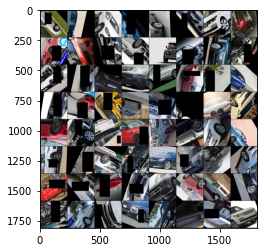

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [42]:
device

device(type='cuda', index=0)

In [43]:
from tqdm import notebook

graphs = {'epochs' : [], 'train_acc' : [], 'train_loss' : [], 'val_acc' : [], 'val_loss' : []}
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    tqdm_e = notebook.tqdm ([i + 1 for i in range (num_epochs)], total = num_epochs)
    for i, epoch in enumerate (tqdm_e):
        graphs['epochs'].append (epoch)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print ('Training for Epoch ' + str (epoch) + '... ' + phase)
            tqdm_tl = notebook.tqdm (dataloaders[phase], total = int (len (dataloaders[phase])))
            for inputs, labels in (tqdm_tl):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val':
                graphs['val_acc'].append (epoch_acc.item ())
                graphs['val_loss'].append (epoch_loss)
            else:
                graphs['train_acc'].append (epoch_acc.item ())
                graphs['train_loss'].append (epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [44]:
model_ft = models.resnet18 (pretrained=True)
num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#model.to(device)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

for name, child in model_ft.named_children():
    print(name)

print(model_ft.fc)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
Linear(in_features=512, out_features=1000, bias=True)


In [45]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Training for Epoch 1... train



train Loss: 2.1934 Acc: 0.4857
Training for Epoch 1... val



val Loss: 0.8594 Acc: 0.6150

Training for Epoch 2... train



train Loss: 0.7283 Acc: 0.6961
Training for Epoch 2... val



val Loss: 0.7156 Acc: 0.6909

Training for Epoch 3... train



train Loss: 0.6072 Acc: 0.7503
Training for Epoch 3... val



val Loss: 0.6343 Acc: 0.7311

Training for Epoch 4... train



train Loss: 0.5610 Acc: 0.7605
Training for Epoch 4... val



val Loss: 0.4427 Acc: 0.8224

Training for Epoch 5... train



train Loss: 0.5214 Acc: 0.7754
Training for Epoch 5... val



val Loss: 0.3586 Acc: 0.8531

Training for Epoch 6... train



train Loss: 0.4793 Acc: 0.8007
Training for Epoch 6... val



val Loss: 0.3761 Acc: 0.8542

Training for Epoch 7... train



train Loss: 0.4535 Acc: 0.8117
Training for Epoch 7... val



val Loss: 0.4423 Acc: 0.8101

Training for Epoch 8... train



train Loss: 0.4174 Acc: 0.8281
Training for Epoch 8... val



val Loss: 0.3598 Acc: 0.8493

Training for Epoch 9... train



train Loss: 0.4256 Acc: 0.8246
Training for Epoch 9... val



val Loss: 0.3438 Acc: 0.8601

Training for Epoch 10... train



train Loss: 0.4155 Acc: 0.8266
Training for Epoch 10... val



val Loss: 0.3505 Acc: 0.8580


Training complete in 30m 52s
Best val Acc: 0.860140


In [46]:
print (graphs)

{'epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_acc': [0.4857142857142857, 0.6961490683229814, 0.7503105590062112, 0.760496894409938, 0.7754037267080746, 0.8007453416149068, 0.8116770186335404, 0.8280745341614907, 0.8245962732919255, 0.8265838509316771], 'train_loss': [2.1934356090444957, 0.7283457726721437, 0.607247309625519, 0.5609921662703804, 0.5214138995786631, 0.4792809725696256, 0.45351660466342236, 0.4173985213596628, 0.425640754870006, 0.4154801790980819], 'val_acc': [0.615034965034965, 0.6909090909090909, 0.7311188811188811, 0.8223776223776224, 0.8531468531468531, 0.8541958041958042, 0.8101398601398602, 0.8493006993006993, 0.8601398601398601, 0.858041958041958], 'val_loss': [0.8593790321916966, 0.7156178799542514, 0.6343279637656846, 0.44270605386553946, 0.3586418476971713, 0.37605974836782974, 0.44229615218155865, 0.3598334246165269, 0.34382058019404643, 0.3505115360646815]}


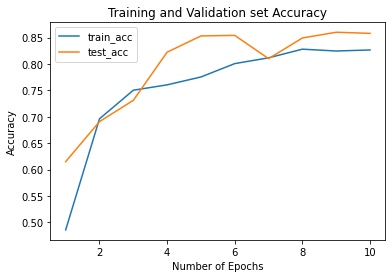

In [47]:
plt.plot (graphs['epochs'][:50], graphs['train_acc'], label = 'train_acc')
plt.plot (graphs['epochs'][:50], graphs['val_acc'], label = 'test_acc')
plt.xlabel ('Number of Epochs')
plt.ylabel ('Accuracy')
plt.title ('Training and Validation set Accuracy')
plt.legend ()
plt.show ()

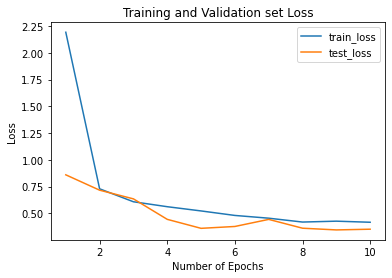

In [48]:
plt.plot (graphs['epochs'][:50], graphs['train_loss'], label = 'train_loss')
plt.plot (graphs['epochs'][:50], graphs['val_loss'], label = 'test_loss')
plt.xlabel ('Number of Epochs')
plt.ylabel ('Loss')
plt.title ('Training and Validation set Loss')
plt.legend ()
plt.show ()

In [49]:
def visualize_model(model, abcd, num_images=10):
    print (class_names[abcd])
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, ax = plt.subplots (2, 5, figsize = (40, 15))
    x = 0
    y = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if labels[j] != abcd or preds[j] == labels[j]:
                    continue
                images_so_far += 1
                #ax.axis('off')
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                z = inputs.cpu().data[j]
                z = z.numpy().transpose((1, 2, 0))
                z = np.clip (z, 0, 1)

                ax[y, x].axis ('off')
                ax[y, x].set_title ('pred as {}'.format(class_names[preds[j]]), fontdict={'fontsize': 22, 'fontweight': 'medium'})
                ax[y, x].imshow (z)
                
                x += 1
                if x == 5:
                    y += 1
                    x = 0
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

rover


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fb7d3cf4eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fb7d3cf4eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel

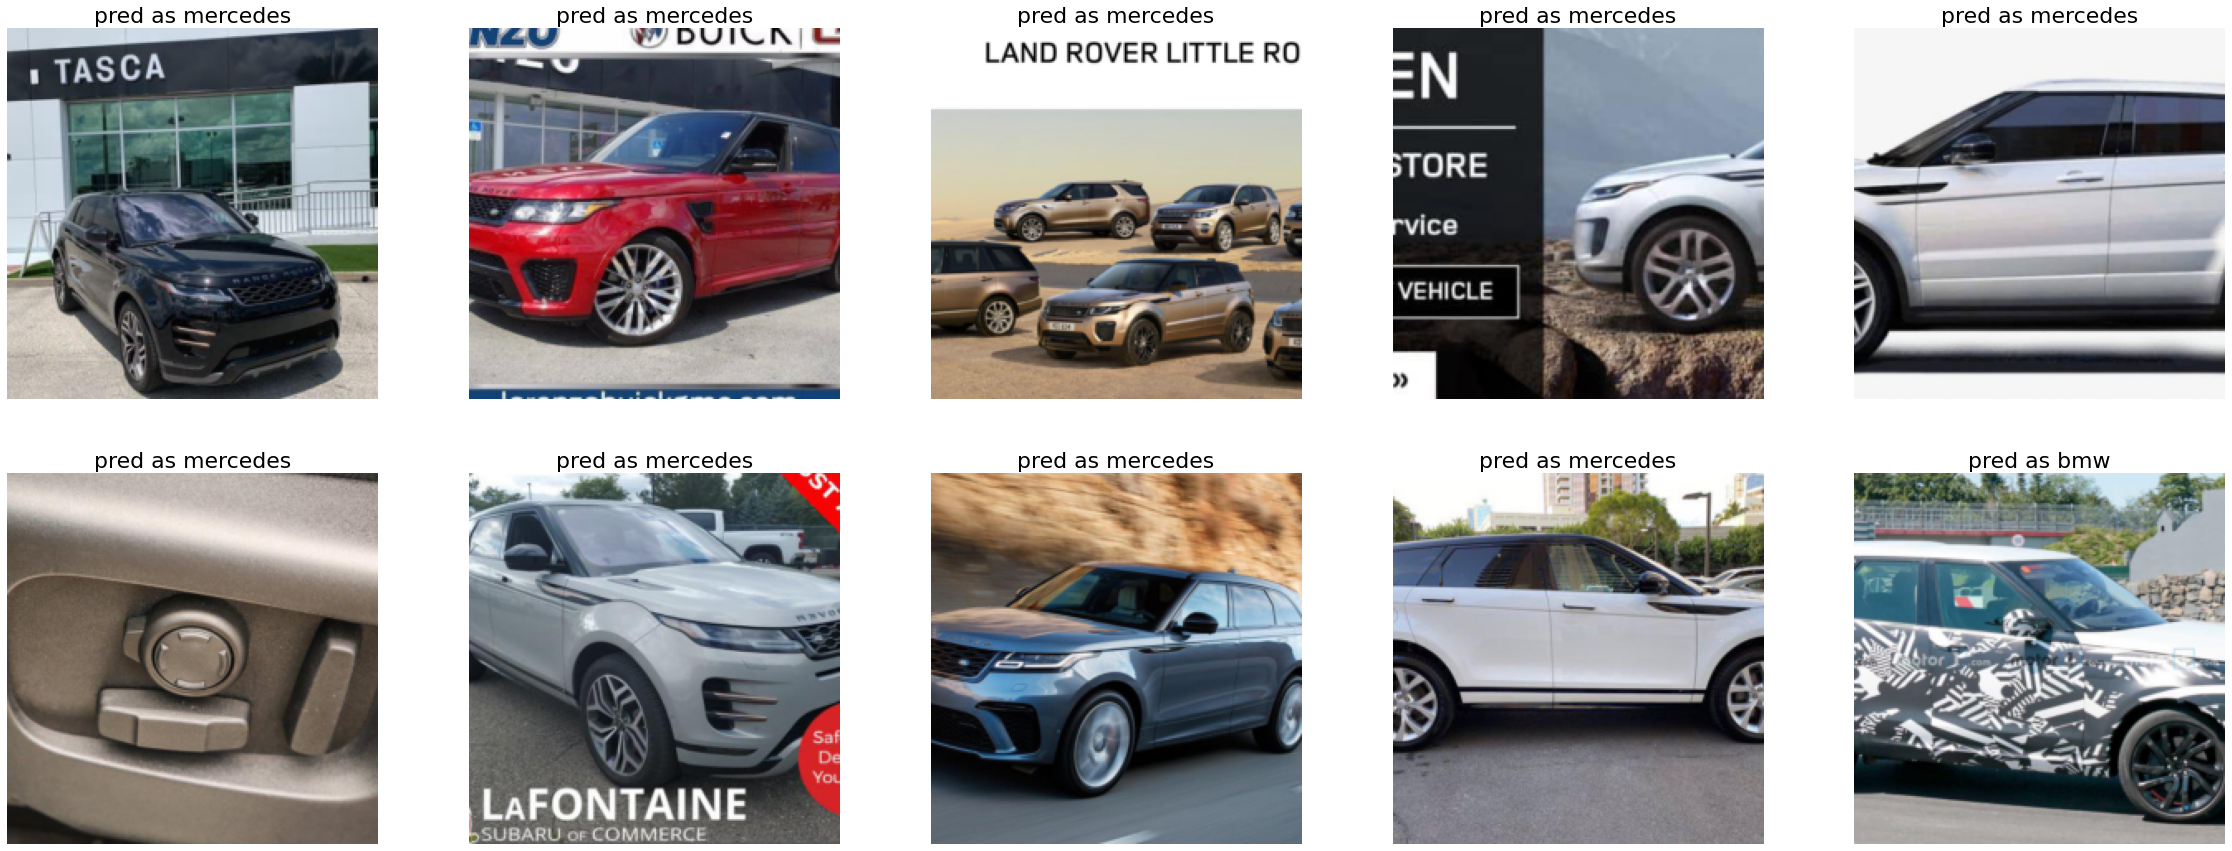

In [50]:
#model_ft = model_ft.to (device)
visualize_model(model_ft, 2)

In [51]:
print (model_ft)
#model_ft = model_ft.to ('cpu')
#model_ft.eval ()
#traced_model = torch.jit.trace (model_ft, torch.randn (1, 3, 224, 224))
#traced_model.save ('/content/drive/My Drive/eva/mobilenet_custom.pt')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
import json
with open ('/content/drive/My Drive/eva/class_names.json', 'w') as openfile:
  json.dump (class_names, openfile)

FileNotFoundError: ignored